In [1]:
import os

notebook_idenifier = "amex_lgbm"
model_identifier = "selected_features"

In [3]:
#thanks to @ambrosm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from cycler import cycler
from IPython.display import display
import datetime
import scipy.stats as stats
import warnings
from colorama import Fore, Back, Style
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibrationDisplay
import lightgbm
from lightgbm import LGBMClassifier, log_evaluation

plt.rcParams['axes.facecolor'] = '#e8e3e3' 
plt.rcParams['axes.prop_cycle'] = cycler(color=['#0c7bdc'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][3:])
plt.rcParams['text.color'] = 'b'

INFERENCE = False # set to False if you only want to cross-validate

In [4]:
train = pd.read_csv("../data/xgb_preprocessed/train_data.csv")
#test = pd.read_csv("../data/xgb_preprocessed/test_data.csv")

In [5]:
# @yunchonggan's fast metric implementation
# From https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
def amex_metric(y_true: np.array, y_pred: np.array) -> float:

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting by descring prediction values
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

def lgb_amex_metric(y_true, y_pred):
    """The competition metric with lightgbm's calling convention"""
    return ('amex',
            amex_metric(y_true, y_pred),
            True)

In [6]:
target = pd.read_csv('../data/train_labels.csv').target.values

In [7]:
train["customer_ID"] = train.index
print(train.shape)
train.head()

(458913, 484)


,B_1_last,B_2_last,B_3_last,B_4_last,B_5_last,B_6_last,B_7_last,B_8_last,B_9_last,B_10_last,...,c_DP_355,c_DP_39r,c_PB_49,c_PR_41,c_BB93,c_BB1825,c_BB1920,c_R3R2,c_DDR6227,customer_ID
0,0.009382,1.007647,0.007174,5,0.231717,0.149564,0.058425,0.000000,0.009535,0.326101,...,0.297677,1.000000,96.348510,62.037540,0.221129,-1.027906,5.0001,10.0,0.223089,0
1,0.034684,1.004028,0.005068,1,0.027000,0.167634,0.028411,0.000000,0.012926,0.297130,...,0.063419,60001.001516,130.263090,70.111540,0.700775,-1.022226,1.0001,10010.0,0.117040,1
2,0.004284,0.812650,0.007196,2,0.001557,0.183628,0.026981,0.000000,0.009392,0.296313,...,0.157484,1.000000,94.920845,65.499540,0.377568,-1.027532,2.0001,10.0,0.219482,2
3,0.012564,1.006183,0.009937,0,0.118818,0.174331,0.011969,1.005561,0.020526,0.411625,...,0.031986,1.000000,206.261840,79.287790,1.425827,-1.025859,0.0001,20010.0,0.217254,3
4,0.007679,0.815746,0.005528,21,0.004855,0.048857,0.159818,1.005185,0.004027,0.125195,...,0.445502,1.000000,41.272617,13.473127,0.033328,-0.559481,21.0001,10.0,0.211179,4


In [8]:
#test["customer_ID"] = test.index
#print(test.shape)
#test.head()

In [9]:
z = np.abs(stats.zscore(train))
threshold = 4
fixer = np.where(z > threshold)
fixer
print(len(fixer[0]))
print(len(fixer[1]))

#Holy wow, 93000 datapoints with z-scores greater than 4 (that's not .004% --> Not normally distributed data)
fixer[0],fixer[1]

975672
975672


(array([     0,      0,      0, ..., 458909, 458909, 458909], dtype=int64),
 array([ 73, 320, 397, ..., 282, 356, 421], dtype=int64))

In [10]:
fixer = pd.DataFrame(fixer)
fixer.head()

,0,1,2,3,4,5,6,7,8,9,...,975662,975663,975664,975665,975666,975667,975668,975669,975670,975671
0,0,0,0,8,8,8,8,8,8,9,...,458902,458906,458908,458908,458908,458909,458909,458909,458909,458909
1,73,320,397,151,185,329,338,356,358,67,...,455,68,72,398,465,88,128,282,356,421


In [11]:
fixer.iloc[1].value_counts()

135    23208
323    17926
107    14962
74     14075
72     13575
       ...  
355       34
327       31
370       15
239       12
416        1
Name: 1, Length: 239, dtype: int64

In [12]:
#have to use a model that will account for those 234 features (nearly half) = lgbm or keras
fixer = []
gc.collect()

0

In [13]:
%%time
# Cross-validation of the classifier

ONLY_FIRST_FOLD = False

#to train model on all features use the next line
#features = [f for f in train.columns if f != 'customer_ID' and f != 'target' ]

#to limit model to "important" features based on random test uncomment the next line
features = ['D_46_last', 'D_43_avg', 'D_43_last', 'S_3_last', 'D_46_avg', 'D_46_min', 'B_3_last', 'D_48_last', 'P_3_avg', 'B_5_last', 'P_3_last', 'S_3_avg', 'D_43_max', 'B_4_max', 'S_7_min', 'S_9_avg', 'B_4_last', 'B_17_last', 'D_46_max', 'P_3_max', 'S_3_max', 'c_PR_21', 'B_17_min', 'D_61_last', 'S_7_last', 'D_62_min', 'P_2_min', 'B_2_last', 'c_DP_239', 'R_27_min', 'S_9_min', 'B_1_last', 'D_47_avg', 'c_DP_348', 'S_12_avg', 'B_17_max', 'S_23_max', 'D_77_max', 'D_105_max', 'S_9_last', 'R_27_max', 'D_77_avg', 'S_27_max', 'D_62_last', 'S_7_max', 'R_27_avg', 'S_3_min', 'P_3_min', 'D_48_min', 'P_2_avg', 'S_12_min', 'D_121_avg', 'R_27_last', 'S_27_last', 'B_3_max', 'c_PB_29', 'D_61_max', 'S_26_last', 'S_25_max', 'P_2_last', 'D_47_max', 'D_69_avg', 'c_DP_355', 'S_5_last', 'B_15_last', 'S_19_last', 'B_24_last', 'D_48_max', 'B_17_avg', 'S_11_avg', 'B_11_last', 'S_25_last', 'D_52_last', 'B_10_last', 'D_39_max', 'S_23_avg', 'B_5_min', 'a_DP_239', 'B_9_avg', 'D_69_last', 'S_26_max', 'D_61_avg', 'R_1_last', 'P_2_max', 'S_7_avg', 'D_62_avg', 'D_47_last', 'B_40_max', 'R_1_avg', 'D_121_max', 'D_119_min', 'S_12_last', 'B_14_last', 'D_121_last', 'S_25_min', 'S_15_avg', 'B_9_max', 'B_37_last', 'R_3_avg', 'D_102_max', 'B_2_min', 'S_23_last', 'B_28_min', 'D_133_max', 'R_6_last', 'D_118_min', 'B_9_last', 'S_16_last', 'S_16_max', 'D_133_avg', 'B_5_max', 'B_21_avg', 'D_60_last', 'B_26_last', 'S_12_max', 'D_48_avg', 'D_52_max', 'S_23_min', 'S_24_last', 'D_42_avg', 'D_121_min', 'B_7_last', 'D_58_max', 'D_71_last', 'B_36_last', 'S_5_max', 'B_21_max', 'S_22_last', 'B_18_last', 'D_133_last', 'D_144_max', 'S_5_avg', 'S_5_min', 'R_1_max', 'D_144_avg', 'D_42_min', 'B_15_min', 'B_24_max', 'D_59_avg', 'R_1_min', 'B_12_avg', 'D_55_min', 'D_105_last', 'D_144_min', 'S_26_avg', 'S_25_avg', 'D_60_max', 'D_115_min', 'S_16_avg', 'D_42_max', 'D_56_min', 'B_2_avg', 'B_8_last', 'S_22_avg', 'B_8_avg', 'B_5_avg', 'D_45_avg', 'D_45_last', 'B_15_max', 'D_119_avg', 'B_21_last']


def my_booster(random_state=1, n_estimators=1150):
    return LGBMClassifier(n_estimators=n_estimators,
                          learning_rate=0.03, reg_lambda=50,
                          min_child_samples=2400,
                          num_leaves=94,
                          colsample_bytree=0.19,
                          max_bins=517, random_state=random_state)
      
print(f"{len(features)} features")
score_list = []
y_pred_list = []
kf = StratifiedKFold(n_splits=5)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train, target)):
    X_tr, X_va, y_tr, y_va, model = None, None, None, None, None
    start_time = datetime.datetime.now()
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y_tr = target[idx_tr]
    y_va = target[idx_va]
    
    model = my_booster()
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(X_tr, y_tr,
                  eval_set = [(X_va, y_va)], 
                  eval_metric=[lgb_amex_metric],
                  callbacks=[log_evaluation(100)])
    X_tr, y_tr = None, None
    y_va_pred = model.predict_proba(X_va, raw_score=True)
    score = amex_metric(y_va, y_va_pred)
    n_trees = model.best_iteration_
    if n_trees is None: n_trees = model.n_estimators
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    
    if INFERENCE:
        y_pred_list.append(model.predict_proba(test[features], raw_score=True))
        
    if ONLY_FIRST_FOLD: break # we only want the first fold
    
print(f"{Fore.GREEN}{Style.BRIGHT}OOF Score:                       {np.mean(score_list):.5f}{Style.RESET_ALL}")

161 features
[100]	valid_0's binary_logloss: 0.249941	valid_0's amex: 0.759947
[200]	valid_0's binary_logloss: 0.231838	valid_0's amex: 0.775969
[300]	valid_0's binary_logloss: 0.227082	valid_0's amex: 0.782413
[400]	valid_0's binary_logloss: 0.224946	valid_0's amex: 0.785166
[500]	valid_0's binary_logloss: 0.223745	valid_0's amex: 0.786374
[600]	valid_0's binary_logloss: 0.222987	valid_0's amex: 0.787362
[700]	valid_0's binary_logloss: 0.222532	valid_0's amex: 0.788112
[800]	valid_0's binary_logloss: 0.222312	valid_0's amex: 0.788438
[900]	valid_0's binary_logloss: 0.222099	valid_0's amex: 0.788559
[1000]	valid_0's binary_logloss: 0.221952	valid_0's amex: 0.789014
[1100]	valid_0's binary_logloss: 0.22187	valid_0's amex: 0.788753
Fold 0 | 01:16 |  1150 trees |                Score = 0.78782
[100]	valid_0's binary_logloss: 0.248906	valid_0's amex: 0.757896
[200]	valid_0's binary_logloss: 0.23094	valid_0's amex: 0.771763
[300]	valid_0's binary_logloss: 0.226281	valid_0's amex: 0.779184
[

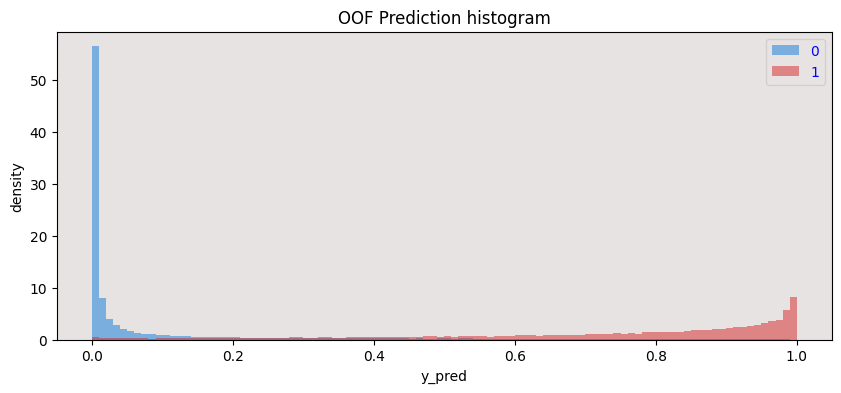

In [14]:
def sigmoid(log_odds):
    return 1 / (1 + np.exp(-log_odds))

plt.figure(figsize=(10, 4))
plt.hist(sigmoid(y_va_pred[y_va == 0]), bins=np.linspace(0, 1, 101),
         alpha=0.5, density=True, label='0')
plt.hist(sigmoid(y_va_pred[y_va == 1]), bins=np.linspace(0, 1, 101),
         alpha=0.5, density=True, label='1')
plt.xlabel('y_pred')
plt.ylabel('density')
plt.title('OOF Prediction histogram', color='black')
plt.legend()
plt.show()

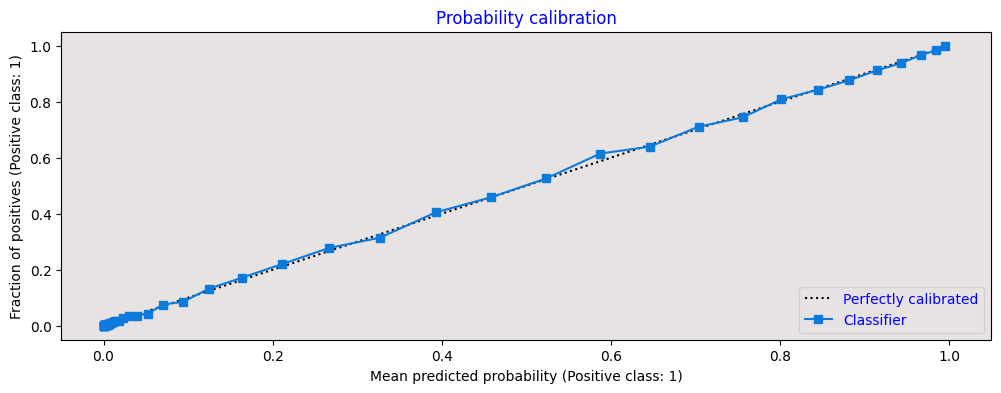

In [15]:
plt.figure(figsize=(12, 4))
CalibrationDisplay.from_predictions(y_va, sigmoid(y_va_pred), n_bins=50,
                                    strategy='quantile', ax=plt.gca())
plt.title('Probability calibration')
plt.show()

In [ ]:
#if INFERENCE:
#    sub = pd.DataFrame({'customer_ID': test.index,
#                        'prediction': np.mean(y_pred_list, axis=0)})
#    sub.to_csv('submission.csv', index=False)
#    display(sub)

In [ ]:
#plt.figure(figsize=(12, 4))
#plt.hist(sigmoid(sub.prediction), bins=np.linspace(0, 1, 101), density=True)
#plt.hist(sigmoid(y_va_pred), bins=np.linspace(0, 1, 101), rwidth=0.5, color='#ffffff', density=True)
#plt.show()

In [ ]:
#import os
#for dirname, _, filenames in os.walk('/kaggle'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))


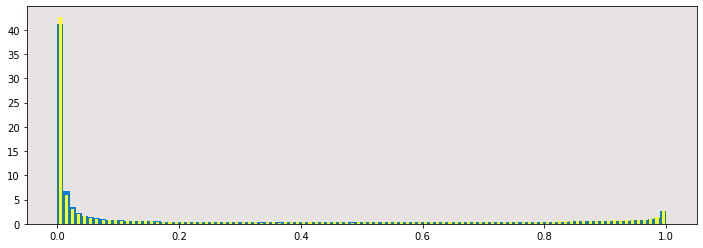

In [17]:
#plt.figure(figsize=(12, 4))
#plt.hist(sigmoid(sub.prediction), bins=np.linspace(0, 1, 101), density=True)
#plt.hist(sigmoid(y_va_pred), bins=np.linspace(0, 1, 101), rwidth=0.5, color='yellow', density=True)
#plt.show()

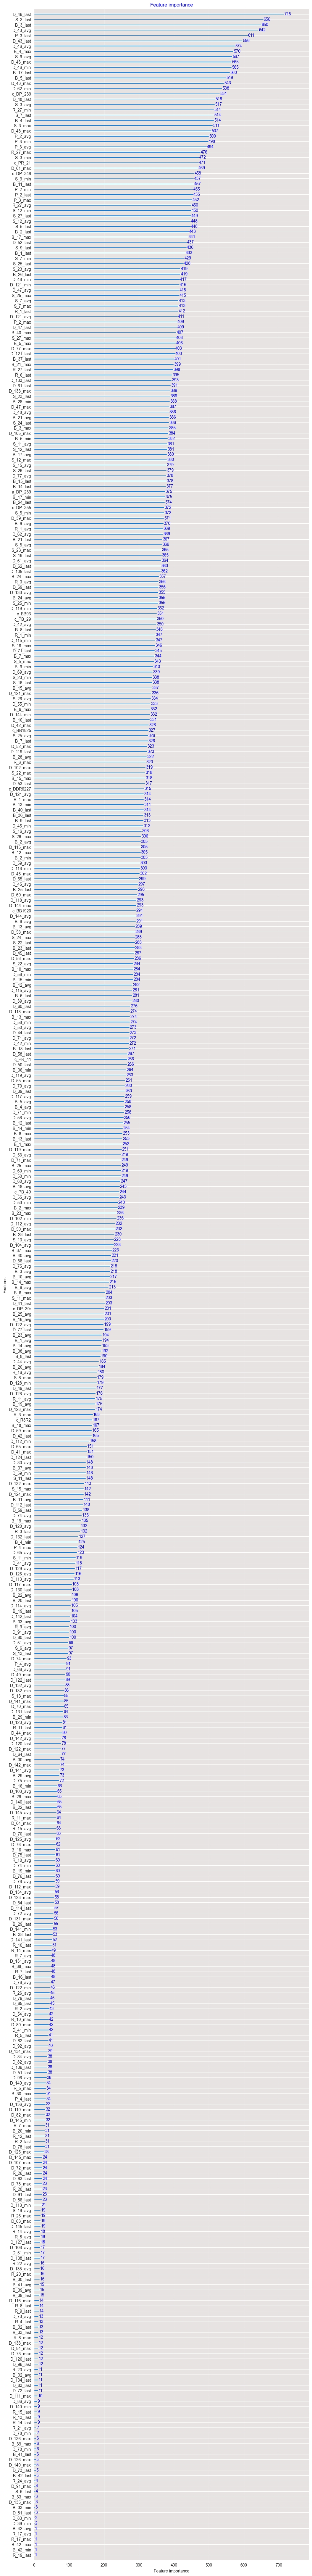

In [23]:
y = lightgbm.plot_importance(model, figsize=(12,112))


In [16]:
vectors = train.columns.tolist()
#vectors = vectors.remove('customer_ID')
#print(vectors)
importance_df = (
     pd.DataFrame({
         'feature_name': vectors,
         'importance_gain': model.feature_importances_
         #(importance_type='gain'),
         #'importance_split': model.feature_importances_(importance_type='split')
                                                    
     })
     .sort_values('importance_gain',ascending=False)
#     .reset_index(drop=True)
    )
y = importance_df.loc[importance_df['importance_gain']>100]
print(y)
z = y['feature_name'].tolist()
print(z)

ValueError: All arrays must be of the same length

In [17]:
#running classifier with all features nets a .795 score.
#what remains below are outputs to avoid reruns...
#first those features with importance over 300, then 200, then 100


#running classifier with these features (with importance over 300) from raw list --> .788 accuracy result
#   feature_name  importance_gain
# 41     D_46_last              748
# 366     D_43_avg              716
# 38     D_43_last              703
# 111     S_3_last              658
# 369     D_46_avg              647
# ..           ...              ...
# 368     D_45_avg              307
# 40     D_45_last              306
# 218     B_15_max              305
# 409    D_119_avg              305
# 20     B_21_last              302

# [161 rows x 2 columns]
# ['D_46_last', 'D_43_avg', 'D_43_last', 'S_3_last', 'D_46_avg', 'D_46_min', 'B_3_last', 'D_48_last', 'P_3_avg', 'B_5_last', 'P_3_last', 'S_3_avg', 'D_43_max', 'B_4_max', 'S_7_min', 'S_9_avg', 'B_4_last', 'B_17_last', 'D_46_max', 'P_3_max', 'S_3_max', 'c_PR_21', 'B_17_min', 'D_61_last', 'S_7_last', 'D_62_min', 'P_2_min', 'B_2_last', 'c_DP_239', 'R_27_min', 'S_9_min', 'B_1_last', 'D_47_avg', 'c_DP_348', 'S_12_avg', 'B_17_max', 'S_23_max', 'D_77_max', 'D_105_max', 'S_9_last', 'R_27_max', 'D_77_avg', 'S_27_max', 'D_62_last', 'S_7_max', 'R_27_avg', 'S_3_min', 'P_3_min', 'D_48_min', 'P_2_avg', 'S_12_min', 'D_121_avg', 'R_27_last', 'S_27_last', 'B_3_max', 'c_PB_29', 'D_61_max', 'S_26_last', 'S_25_max', 'P_2_last', 'D_47_max', 'D_69_avg', 'c_DP_355', 'S_5_last', 'B_15_last', 'S_19_last', 'B_24_last', 'D_48_max', 'B_17_avg', 'S_11_avg', 'B_11_last', 'S_25_last', 'D_52_last', 'B_10_last', 'D_39_max', 'S_23_avg', 'B_5_min', 'a_DP_239', 'B_9_avg', 'D_69_last', 'S_26_max', 'D_61_avg', 'R_1_last', 'P_2_max', 'S_7_avg', 'D_62_avg', 'D_47_last', 'B_40_max', 'R_1_avg', 'D_121_max', 'D_119_min', 'S_12_last', 'B_14_last', 'D_121_last', 'S_25_min', 'S_15_avg', 'B_9_max', 'B_37_last', 'R_3_avg', 'D_102_max', 'B_2_min', 'S_23_last', 'B_28_min', 'D_133_max', 'R_6_last', 'D_118_min', 'B_9_last', 'S_16_last', 'S_16_max', 'D_133_avg', 'B_5_max', 'B_21_avg', 'D_60_last', 'B_26_last', 'S_12_max', 'D_48_avg', 'D_52_max', 'S_23_min', 'S_24_last', 'D_42_avg', 'D_121_min', 'B_7_last', 'D_58_max', 'D_71_last', 'B_36_last', 'S_5_max', 'B_21_max', 'S_22_last', 'B_18_last', 'D_133_last', 'D_144_max', 'S_5_avg', 'S_5_min', 'R_1_max', 'D_144_avg', 'D_42_min', 'B_15_min', 'B_24_max', 'D_59_avg', 'R_1_min', 'B_12_avg', 'D_55_min', 'D_105_last', 'D_144_min', 'S_26_avg', 'S_25_avg', 'D_60_max', 'D_115_min', 'S_16_avg', 'D_42_max', 'D_56_min', 'B_2_avg', 'B_8_last', 'S_22_avg', 'B_8_avg', 'B_5_avg', 'D_45_avg', 'D_45_last', 'B_15_max', 'D_119_avg', 'B_21_last']

In [18]:
import pickle
import shap

In [19]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(480)
features = train.iloc[select]
features_display = train.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

print(f'shap_values: {shap_values}')
print(f'shap_interaction_values: {shap_interaction_values}')


Explainer expected value: [-2.93307824]


LightGBMError: The number of features in data (484) is not the same as it was in training data (161).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [ ]:
shap.decision_plot(expected_value, shap_values, features_display)

# visually this didn't change with the reduction in features, (but we're only looking at 20)
# There was no noticeable horizontal shift gains between the outputs


In [ ]:
import os

In [20]:
os.makedirs(f"../model_weights/{notebook_idenifier}/{model_identifier}",exist_ok=True)
model.booster_.save_model(f'../model_weights/{notebook_idenifier}/{model_identifier}/model_0.78.txt')